# Sistema de Recomendación de Películas

Este notebook crea un sistema de recomendación que sugiere películas del Top 250 de IMDB basado en:
- Ratings personales en Letterboxd
- Año de la película
- Géneros
- Actores involucrados
- Directores

## 1. Configuración Inicial
Primero, instalamos e importamos las librerías necesarias.

In [ ]:
# Instalación de paquetes (ejecutar solo una vez)
!pip install imdbpy scikit-learn pandas numpy matplotlib seaborn

In [1]:
# Importaciones
import pandas as pd
import numpy as np
from imdb import IMDb
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
ia = IMDb()

## 2. Carga de Datos

Cargamos tus ratings de Letterboxd y el Top 250 de IMDB.

**Nota**: Se asume que se tienen estos archivos CSV.

In [2]:
def cargar_datos():
    """Carga y prepara los datasets"""
    # Cargar tus ratings de Letterboxd (ajusta los nombres de columnas)
    letterboxd = pd.read_csv('letterboxd_ratings.csv')
    letterboxd = letterboxd.rename(columns={
        'Name': 'title',
        'Year': 'year',
        'Rating': 'rating'
    })

    # Cargar Top 250 de IMDB (puedes generarlo con imdbpy si no tienes el CSV)
    imdb_top = pd.read_csv('imdb_top250.csv')
    imdb_top = imdb_top.rename(columns={
        'name': 'title',
        'year': 'year',
        'rating': 'imdb_rating'
    })

    return letterboxd, imdb_top

In [3]:
letterboxd_ratings, imdb_top250 = cargar_datos()

## 3. Enriquecimiento de Datos

Vamos a obtener información adicional de IMDB para las películas calificadas.

In [4]:
def obtener_info_imdb(title, year):
    """Obtiene datos de IMDB con manejo de errores y caché"""
    try:
        resultados = ia.search_movie(f"{title} {year}")
        if not resultados:
            return None

        pelicula = ia.get_movie(resultados[0].movieID)

        return {
            'title': pelicula.get('title', title),
            'year': pelicula.get('year', year),
            'imdb_rating': pelicula.get('rating', np.nan),
            'genres': pelicula.get('genres', []),
            'directors': [d['name'] for d in pelicula.get('directors', [])],
            'actors': [a['name'] for a in pelicula.get('actors', [])[:3]],
            'runtime': pelicula.get('runtime', [0])[0] if pelicula.get('runtime') else 0
        }
    except Exception:
        return None

In [5]:
def enriquecer_fila(fila, es_letterboxd):
    """Enriquece una fila con datos de IMDb"""
    info = obtener_info_imdb(str(fila['title']), fila['year'])
    if info and es_letterboxd:
        info['user_rating'] = fila['rating']
    return info

In [6]:
def enriquecer_datos(df, es_letterboxd=True, max_workers=15):
    """Añade datos de IMDB a un DataFrame usando concurrencia"""
    datos_enriquecidos = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futuros = {executor.submit(enriquecer_fila, fila, es_letterboxd): fila for _, fila in df.iterrows()}
        for futuro in tqdm(as_completed(futuros), total=len(futuros)):
            resultado = futuro.result()
            if resultado:
                datos_enriquecidos.append(resultado)
    return pd.DataFrame(datos_enriquecidos)

In [7]:
# Enriquecer datos
print("\nEnriqueciendo tus ratings de Letterboxd...")
letterboxd_enriched = enriquecer_datos(letterboxd_ratings)

print("\nEnriqueciendo Top 250 de IMDB...")
imdb_enriched = enriquecer_datos(imdb_top250, es_letterboxd=False)

# Mostrar resultados
print(f"\nPelículas enriquecidas: {len(letterboxd_enriched)}/{len(letterboxd_ratings)}")
display(letterboxd_enriched.head(2))


Enriqueciendo tus ratings de Letterboxd...


100%|██████████| 269/269 [02:06<00:00,  2.13it/s]



Enriqueciendo Top 250 de IMDB...


100%|██████████| 250/250 [01:39<00:00,  2.50it/s]


Películas enriquecidas: 269/269


,title,year,imdb_rating,genres,directors,actors,runtime,user_rating
0,Rogue One: A Star Wars Story,2016,8.0,[Adventure],[],[Jonathan Davis],0,3.5
1,Bolt,2008,6.8,"[Animation, Adventure, Comedy, Crime, Drama, F...","[Byron Howard, Chris Williams]","[John Travolta, Miley Cyrus, Susie Essman]",96,5.0


## 4. Preprocesamiento de Datos

In [9]:
# Combinar los datos para el modelo
all_movies = pd.concat([letterboxd_enriched, imdb_enriched]).drop_duplicates(['title', 'year'])

In [10]:
# Convertir géneros, directores y actores en características binarias
genres_mlb = MultiLabelBinarizer()
genres_encoded = genres_mlb.fit_transform(all_movies['genres'])

directors_mlb = MultiLabelBinarizer()
directors_encoded = directors_mlb.fit_transform(all_movies['directors'])

actors_mlb = MultiLabelBinarizer()
actors_encoded = actors_mlb.fit_transform(all_movies['actors'])


In [11]:
# Escalar características numéricas
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(all_movies[['year', 'imdb_rating', 'user_rating']].fillna(0))

## 5. Modelado y Recomendación

In [12]:
# Combinar todas las características
all_features = np.hstack([
    numerical_features,
    genres_encoded,
    directors_encoded,
    actors_encoded
])

In [13]:
# Entrenar modelo de vecinos más cercanos
model = NearestNeighbors(n_neighbors=10, metric='cosine')
model.fit(all_features[:len(letterboxd_enriched)])  # Solo entrenar con tus películas calificadas

NearestNeighbors(metric='cosine', n_neighbors=10)

In [14]:
import ast

def safe_literal_eval(s):
    """Convierte strings como "['Action', 'Drama']" en listas reales."""
    try:
        return ast.literal_eval(s) if isinstance(s, str) else s
    except (ValueError, SyntaxError):
        return []  # Si falla, devuelve lista vacía

# Aplicar a las columnas relevantes
letterboxd_enriched['genres'] = letterboxd_enriched['genres'].apply(safe_literal_eval)
letterboxd_enriched['directors'] = letterboxd_enriched['directors'].apply(safe_literal_eval)
letterboxd_enriched['actors'] = letterboxd_enriched['actors'].apply(safe_literal_eval)
imdb_enriched['genres'] = imdb_enriched['genres'].apply(safe_literal_eval)
imdb_enriched['directors'] = imdb_enriched['directors'].apply(safe_literal_eval)
imdb_enriched['actors'] = imdb_enriched['actors'].apply(safe_literal_eval)

In [15]:
def extract_user_preferences(user_ratings_df):
    """Analiza géneros, directores y años más frecuentes, ignorando valores vacíos o inválidos."""
    # Géneros más comunes (excluyendo strings vacíos o caracteres sueltos)
    genres_flat = [g for genres in user_ratings_df['genres'] for g in genres if isinstance(g, str) and len(g) > 1]
    top_genres = pd.Series(genres_flat).value_counts().index[:3].tolist()

    # Directores más comunes (mismo filtro)
    directors_flat = [d for directors in user_ratings_df['directors'] for d in directors if isinstance(d, str) and len(d) > 1]
    top_directors = pd.Series(directors_flat).value_counts().index[:2].tolist()

    # Directores más comunes (mismo filtro)
    actors_flat = [a for actors in user_ratings_df['actors'] for a in actors if isinstance(a, str) and len(a) > 1]
    top_actors = pd.Series(actors_flat).value_counts().index[:2].tolist()

    preferences = {
        'genres': top_genres if top_genres else ['Drama'],  # Valor por defecto si no hay datos
        'directors': top_directors if top_directors else [],
        'actors': top_actors if top_actors else [],
        'avg_rating': float(user_ratings_df['user_rating'].mean())
    }
    return preferences
user_prefs = extract_user_preferences(letterboxd_enriched)

In [16]:
# 1. Primero, crea el conjunto de películas calificadas
rated_movies = set(
    f"{row['title'].lower().strip()} ({int(row['year'])})"
    for _, row in letterboxd_enriched.iterrows()
)

def recommend_based_on_genres_and_directors(top250_df, user_prefs, rated_movies, n_recommendations=10):
    """
    Recomienda películas del Top 250 que NO estén en tus ratings,
    basado solo en géneros y directores.
    """
    # Filtrar películas no calificadas
    top250_unrated = top250_df[
        ~top250_df.apply(
            lambda row: f"{row['title'].lower().strip()} ({int(row['year'])})" in rated_movies,
            axis=1
        )
    ].copy()

    # Si no hay suficientes películas, relajar el filtro (opcional)
    if len(top250_unrated) < n_recommendations:
        top250_unrated = top250_df.copy()
        print("⚠️ Advertencia: No hay suficientes películas no calificadas. Mostrando algunas del Top 250 igualmente.")

    # Puntuación por géneros y directores (como antes)
    top250_unrated['genre_score'] = top250_unrated['genres'].apply(
        lambda x: sum(1 for g in x if g in user_prefs['genres'])
    )
    top250_unrated['director_score'] = top250_unrated['directors'].apply(
        lambda x: 2 if any(d in x for d in user_prefs['directors']) else 0
    )
    top250_unrated['actor_score'] = top250_unrated['actors'].apply(
        lambda x: 2 if any(a in x for a in user_prefs['actors']) else 0
    )
    top250_unrated['similarity_score'] = (
        top250_unrated['genre_score'] + top250_unrated['director_score'] + top250_unrated['actor_score']
    )

    # Ordenar y retornar
    recommendations = (
        top250_unrated.sort_values('similarity_score', ascending=False)
        .head(n_recommendations)
    )
    return recommendations

In [18]:
# Obtener recomendaciones (excluyendo tus ratings)
recommendations = recommend_based_on_genres_and_directors(
    imdb_enriched,
    user_prefs,
    rated_movies,
    n_recommendations=100
)

# Mostrar algunos resultados
recommendations.head()

,title,year,imdb_rating,genres,directors,actors,runtime,genre_score,director_score,actor_score,similarity_score
243,The Iron Giant,1999,8.1,"[Animation, Action, Adventure, Comedy, Drama, ...",[Brad Bird],"[Jennifer Aniston, Harry Connick Jr., Vin Diesel]",86,3,0,2,5
184,The General,1926,8.1,"[Action, Adventure, Comedy, Drama, War]","[Clyde Bruckman, Buster Keaton]","[Buster Keaton, Marion Mack, Glen Cavender]",78,3,0,0,3
41,The Prestige,2006,8.5,"[Drama, Mystery, Sci-Fi, Thriller]",[Christopher Nolan],"[Hugh Jackman, Christian Bale, Michael Caine]",130,1,2,0,3
144,Yojimbo,1961,8.2,"[Action, Drama, Thriller]",[Akira Kurosawa],"[Toshirô Mifune, Tatsuya Nakadai, Yôko Tsukasa]",110,2,0,0,2
175,The Gold Rush,1925,8.1,"[Adventure, Comedy, Drama, Romance, Western]",[Charles Chaplin],"[Charles Chaplin, Mack Swain, Tom Murray]",95,2,0,0,2


In [19]:
# 3. Exportar a Excel (todas las 100 recomendaciones)
output_path = "recomendaciones_top100.xlsx"
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    # Hoja principal con las 100 películas
    recommendations.to_excel(writer, sheet_name='Top 100', index=False)
    
    # Hojas adicionales por género (opcional)
    for genre in user_prefs['genres']:
        genre_movies = recommendations[
            recommendations['genres'].str.contains(genre, na=False)
        ]
        if not genre_movies.empty:
            genre_movies.to_excel(writer, sheet_name=f'Género {genre[:20]}', index=False)  # Limita el nombre de la hoja

print(f"✅ Archivo exportado con 100 recomendaciones: {output_path}")

✅ Archivo exportado con 100 recomendaciones: recomendaciones_top100.xlsx


## 6. Visualización de Resultados

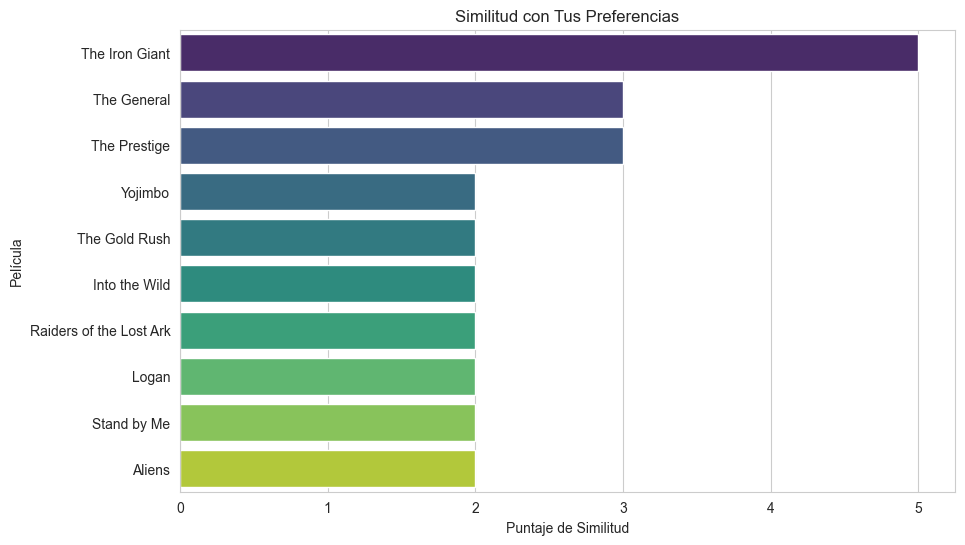

In [20]:
def mostrar_recomendaciones(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='similarity_score',  # Columna correcta
        y='title',
        data=df.sort_values('similarity_score', ascending=False),
        palette='viridis'
    )
    plt.title('Similitud con Tus Preferencias')
    plt.xlabel('Puntaje de Similitud')
    plt.ylabel('Película')
    plt.show()

# Para hybrid_recommendations
recommendations = recommend_based_on_genres_and_directors(imdb_enriched, user_prefs, rated_movies)
mostrar_recomendaciones(recommendations)  # Usando la función actualizada